In [1]:
import mlatom as ml

In [2]:
# here we demonstrate on an example of benzene molecule how to calculate its UV/vis spectrum via NEA approach
# load the initial guess for geometry
mol = ml.data.molecule.from_xyz_string('''12

C        0.00000000      1.39110400      0.00000000
C        1.20473100      0.69555200      0.00000000
C        1.20473100     -0.69555200      0.00000000
C       -0.00000000     -1.39110400      0.00000000
C       -1.20473100     -0.69555200     -0.00000000
C       -1.20473100      0.69555200      0.00000000
H        0.00000000      2.47330200      0.00000000
H        2.14194200      1.23665100      0.00000000
H        2.14194200     -1.23665100      0.00000000
H       -0.00000000     -2.47330200      0.00000000
H       -2.14194200     -1.23665100     -0.00000000
H       -2.14194200      1.23665100      0.00000000
''')

# define the method
aiqm1 = ml.models.methods(method='AIQM1')

# optimize the geometry in the ground state (can be done in a different method than used for calculating excited-state properties)
ml.optimize_geometry(molecule=mol, model=aiqm1)
print('Optimized geometry:\n')
print(mol.get_xyz_string())


Optimized geometry:

12

C             0.0000000000000           1.3925401460472           0.0000000000000
C             1.2059751422665           0.6962700730233           0.0000000000000
C             1.2059751422665          -0.6962700730233           0.0000000000000
C            -0.0000000000000          -1.3925401460472           0.0000000000000
C            -1.2059751422665          -0.6962700730233           0.0000000000000
C            -1.2059751422665           0.6962700730233           0.0000000000000
H             0.0000000000000           2.4748778305515           0.0000000000000
H             2.1433070725205           1.2374389152757           0.0000000000000
H             2.1433070725205          -1.2374389152757           0.0000000000000
H            -0.0000000000000          -2.4748778305515           0.0000000000000
H            -2.1433070725205          -1.2374389152757           0.0000000000000
H            -2.1433070725205           1.2374389152757           0.00000

In [24]:
# we need to obtain an ensemble of geometries. The easiest way through Wigner sampling, but, e.g., MD can be also done.
# here we show for Wigner sampling that requires the frequency calculations
_ = ml.freq(molecule=mol, model=aiqm1)

In [14]:
# check vibrational modes
mol.view(normal_mode=1)

interactive(children=(IntSlider(value=1, description='mode', max=29), Output()), _dom_classes=('widget-interac…

In [15]:
# perform single-point excited-state calculations for comparison (not needed for NEA)
aiqm1.predict(molecule=mol, 
                nstates=30, # Number of electronic states to calculate
                )
# after all this work, let's dump the molecule so that we can re-use the calculations later if needed:
mol.dump(filename='benzene.json', format='json')
# you can load it later as
# mol = ml.molecule.load(filename='benzene.json', format='json')

In [6]:
# get the nuclear ensemble with 100 geometries
ensemble = ml.generate_initial_conditions(molecule=mol,
                                                generation_method='Wigner',
                                                initial_temperature=298,
                                                number_of_initial_conditions=100)

In [8]:
# perform single-point excited-state calculations for the ensemble
aiqm1.predict(molecular_database=ensemble, 
              nstates=30, # Number of electronic states to calculate
              )
# after all this work, let's dump the molecule so that we can re-use the calculations later if needed:
ensemble.dump(filename='benzene_ensemble.json', format='json')
# you can load it later as
#ensemble = ml.molecular_database() ; ensemble.load(filename='benzene_ensemble.json', format='json')

In [10]:
# we can use NEA to obtain UV/vis absorption spectrum from our calculations
spectrum_nea = ml.spectra.uvvis.nea(molecular_database=ensemble, broadening_width=0.02)

In [16]:
# for comparison, we can use single-point convolution to obtain UV/vis absorption spectrum from our calculations
spectrum_spc = ml.spectra.uvvis.spc(molecule=mol, band_width=0.3)

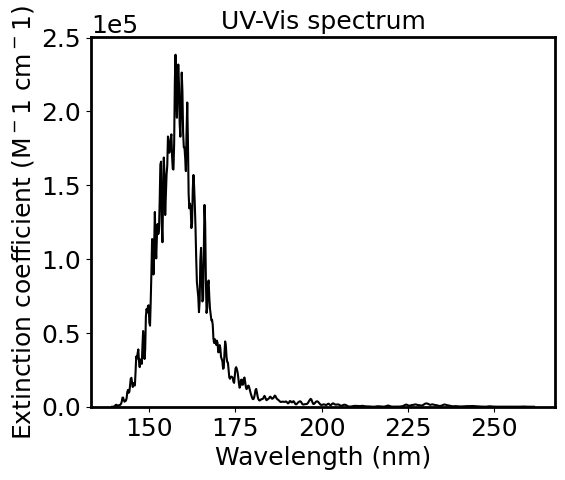

In [17]:
spectrum_nea.plot('UVvis_NEA.png')

In [19]:
# more useful might be comparison to experiment
# let's get the experimental spectrum from file (got from NIST, baseline is not removed)
wavelengths = []
cross_section = []
import numpy as np

raw_data = np.loadtxt(f'benzene_exp.dat').T
exp_spectrum = ml.spectra.uvvis(wavelengths_nm=raw_data[0],molar_absorbance=raw_data[1])

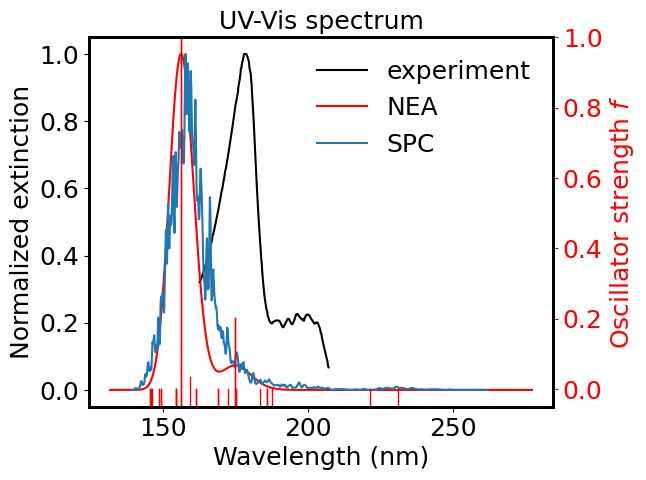

In [ ]:

ml.spectra.plot_uvvis(spectra=[exp_spectrum, spectrum_spc, spectrum_nea], 
               molecule=mol,
               normalize=True,
               labels=['experiment', 'NEA', 'SPC'],
               )